In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("test_pyspark") \
    .config("spark.driver.memory", "100g") \
    .config("spark.executor.memory", "100g") \
    .config("spark.sql.orc.enableVectorizedReader", "false") \
    .config("spark.sql.parquet.columnarReaderBatchSize", "256") \
    .config("spark.sql.orc.columnarReaderBatchSize", "256") \
    .config("spark.sql.shuffle.partitions", "1024") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/17 13:56:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
spark.table("manifests_with_images_and_text")

DataFrame[id: string, manifest_id: string, filename: string, image_ids: array<string>, text: string]

In [ ]:
# Get number of partitions
num_partitions = spark.table("manifests_with_images_and_text").rdd.getNumPartitions()
print(f"Number of partitions: {num_partitions}")

Number of partitions: 292



# Sentence Tokenization

Break down the `text_content` into individual sentences, with each sentence becoming a new row in the DataFrame. This helps in analyzing text at a more granular, sentence level.


In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from collections.abc import Iterator
import nltk
from nltk.tokenize import sent_tokenize
import pandas as pd # Added pandas import

# Ensure punkt is downloaded (run once)
nltk.download('punkt')
nltk.download('punkt_tab')

# Define the output schema: id, sentence, sentence_idx
output_schema = StructType([
    StructField("id", StringType(), True),
    StructField("sentence", StringType(), True),
    StructField("sentence_idx", IntegerType(), True)
])

def split_sentences_mapin(df: Iterator[pd.DataFrame]) -> Iterator[pd.DataFrame]:
    for pdf in df:
        rows = []
        for row in pdf.itertuples(index=False):
            text = str(getattr(row, "text", "")) if getattr(row, "text", None) is not None else ""
            sentences = sent_tokenize(text)
            id_val = getattr(row, "id", None)
            for idx, sent in enumerate(sentences):
                rows.append((id_val, sent.strip(), idx))
        yield pd.DataFrame(rows, columns=["id", "sentence", "sentence_idx"])


# Apply mapInPandas to split sentences, each on its own row, with id and
# sentence_idx
df_sentences = spark.table("manifests_with_images_and_text").repartition(
    1024).mapInPandas(
         split_sentences_mapin, schema=output_schema )
# df_sentences.show(truncate=False)
df_sentences

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


DataFrame[id: string, sentence: string, sentence_idx: int]

In [ ]:
df_sentences.write.mode("overwrite").saveAsTable("alto_sentence")

In [2]:
df_sentences = spark.table("alto_sentence")

# Create Sample of Sentences

In [ ]:
#spark.table("alto_sentence").sample(False, 0.01, seed=42).write.mode("overwrite").saveAsTable("alto_sentence_sample_001pct")

In [14]:
df_sentences = spark.table("alto_sentence_sample_001pct")
df_sentences = df_sentences.repartition(4096)

# LangDetect Language Classification

In [ ]:
# Install langdetect if needed
# !pip install langdetect

from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import StringType
from langdetect import detect, LangDetectException
import pandas as pd

# Define a pandas UDF for better performance with batch processing
@pandas_udf(StringType())
def detect_language_batch(texts: pd.Series) -> pd.Series:
    """
    Detects the language of the given texts using pandas Series.
    Returns the ISO 639-1 language code or 'unknown' if detection fails.
    Much more efficient than regular UDF for large datasets.
    """
    def detect_single(text):
        if not isinstance(text, str) or len(text.strip()) < 5:  # Skip very short texts
            return 'unknown'
        
        try:
            return detect(text)
        except LangDetectException:
            return 'unknown'
    
    return texts.apply(detect_single)


# Apply the Pandas UDF to detect language for each sentence
# This is much more efficient than the regular UDF
df_with_lang_detect_lang = df_sentences.withColumn(
    "language", detect_language_batch("sentence"))

# Show example results
df_with_lang_detect_lang.select(
    "id", "sentence", "language").show(
        10, truncate=200)

+--------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|      id|                                                                                                                                                                                                sentence|language|
+--------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|cp4myqbx|                                                                                                                                                                                          Delepine (S.).|      de|
|ztdrvt9y|                                                                                                          

In [ ]:

# Save as a new table or add to the existing one
df_with_lang_detect_lang.write.mode("overwrite").saveAsTable(
    "alto_sentence_with_langdetect_lang")

In [28]:
df_with_lang_detect_lang = spark.table("alto_sentence_with_langdetect_lang")

In [29]:

# Get language distribution
langdetect_lang_distribution = df_with_lang_detect_lang.groupBy(
    "language").count().orderBy("count", ascending=False)
langdetect_lang_distribution.show(20)

+--------+-------+
|language|  count|
+--------+-------+
|      en|2783491|
|      de| 617602|
| unknown| 568668|
|      fr| 508406|
|      ca| 131977|
|      it| 124714|
|      ro| 115132|
|      cy|  76169|
|      pt|  73853|
|      vi|  61397|
|      es|  60144|
|      nl|  53071|
|      da|  41128|
|      tl|  38516|
|      af|  35071|
|      no|  31242|
|      id|  28877|
|      et|  24176|
|      so|  23880|
|      sv|  23282|
+--------+-------+
only showing top 20 rows



# FastText Language Classification

FastText provides a more efficient and accurate language classification than langdetect. It uses a hierarchical classifier with a linear model for text classification and can recognize 176 languages.

In [21]:
import os
import requests

# Download the FastText language identification model using Python
model_path = '../data/tmp/lid.176.bin'
model_url = 'https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin'

if not os.path.exists(model_path):
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    print("Downloading FastText language identification model...")
    with requests.get(model_url, stream=True) as r:
        r.raise_for_status()
        with open(model_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
    print("Download complete.")

In [22]:
import fasttext
import pandas as pd
# Use the already loaded FastText model and model_path

def fasttext_language_mapin(df_iter):
    # Load the model
    model = fasttext.load_model(model_path)

    for pdf in df_iter:        
        def detect_language(text):
            if not isinstance(text, str) or len(text.strip()) < 5:
                return 'unknown'
            try:
                predictions = model.predict(text.replace('\n', ' '))
                lang_code = predictions[0][0].replace('__label__', '')
                return lang_code
            except Exception:
                return 'unknown'
        pdf['fasttext_language'] = pdf['sentence'].apply(detect_language)
        yield pdf[['id', 'sentence', 'sentence_idx', 'fasttext_language']]

# Apply FastText language detection using mapInPandas
df_fasttext_lang = df_sentences.mapInPandas(
    fasttext_language_mapin,
    schema="id string, sentence string, sentence_idx int, fasttext_language string"
)

# Show example results
df_fasttext_lang.select(
    "id",
    "sentence",
    "fasttext_language").show(
        10,
    truncate=100)

+--------+----------------------------------------------------------------------------------------------------+-----------------+
|      id|                                                                                            sentence|fasttext_language|
+--------+----------------------------------------------------------------------------------------------------+-----------------+
|exdbh2tw|                                                                                         Wochenschr.|               de|
|h7j4c9bd|                                                                                          Contracts.|               en|
|ma7tkbcc|Nitric acid (3 pe-r cent, to 50 per cent, in water) is mainly used in embryological work, and is ...|               en|
|jvu3wz5a| Bei beweglich im Eingange stehendem Fruchtheile kann man zuweilen die Rissstelle im Cervix fÃ¼hlen.|               de|
|ybwh8ndm|                                                                                

In [23]:
# Save to a table
df_fasttext_lang.write.mode("overwrite").saveAsTable(
    "alto_sentence_with_fasttext_lang")

In [24]:
df_fasttext_lang = spark.table("alto_sentence_with_fasttext_lang")

In [25]:
# Get FastText language distribution
fasttext_lang_distribution = df_fasttext_lang.groupBy("fasttext_language").count().orderBy("count", ascending=False)
print("\nFastText Language Distribution:")
fasttext_lang_distribution.show(20)



FastText Language Distribution:


+-----------------+-------+
|fasttext_language|  count|
+-----------------+-------+
|               en|3168754|
|               de| 581268|
|               fr| 532786|
|          unknown| 482183|
|               es| 163792|
|               it| 119455|
|               la| 100104|
|               pt|  36054|
|               nl|  28768|
|               ru|  23171|
|               pl|  21625|
|               zh|  20447|
|               eo|  18305|
|               ja|  17906|
|               cs|  17154|
|               hu|  16094|
|               sv|  14489|
|               da|  12492|
|               tr|  12182|
|               uk|  10510|
+-----------------+-------+
only showing top 20 rows



# Language Distribution Visualization

Let's visualize the language distribution using the LangDetect and FastText classifications.

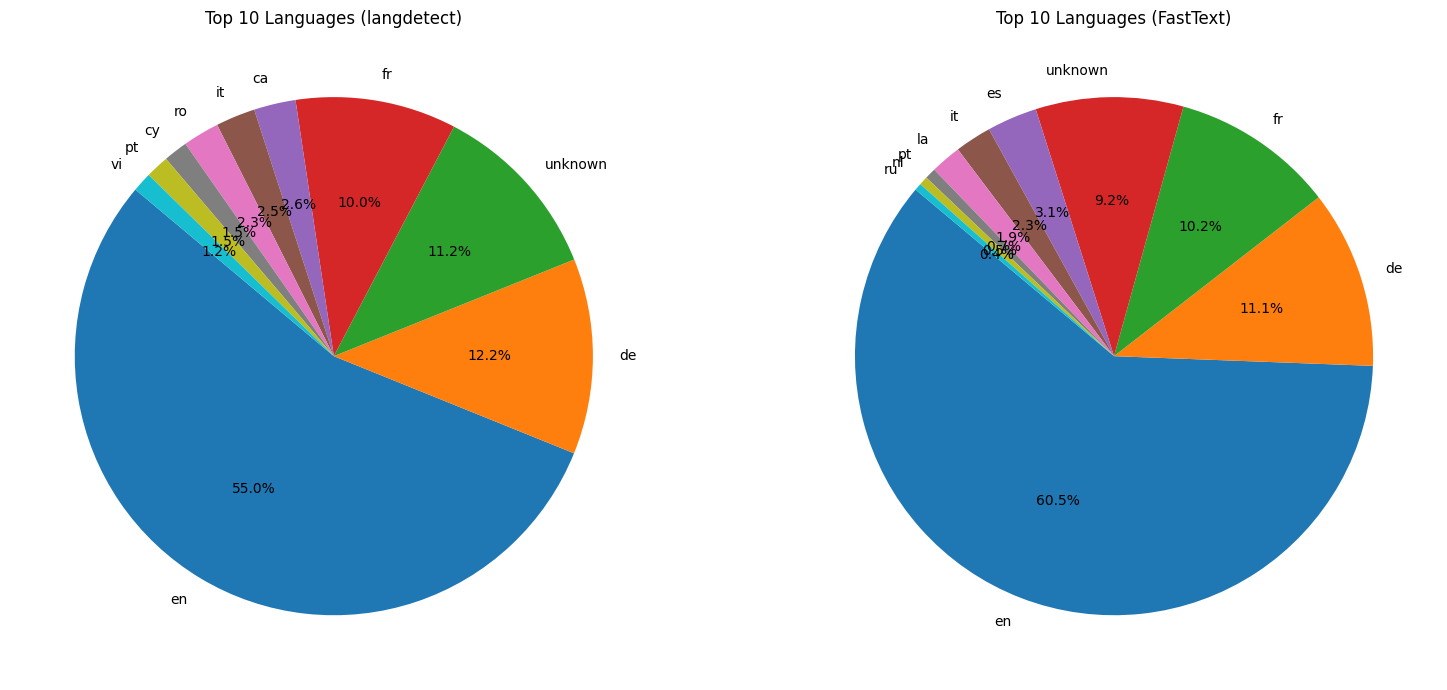

In [31]:
import matplotlib.pyplot as plt

# Create a side-by-side pie chart comparison of top languages from both classifiers
top_langdetect = langdetect_lang_distribution.limit(10).toPandas()
top_fasttext = fasttext_lang_distribution.limit(10).toPandas()

# Pie chart for langdetect
plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
plt.pie(
    top_langdetect["count"],
    labels=top_langdetect["language"],
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Top 10 Languages (langdetect)")

plt.subplot(1, 2, 2)
plt.pie(
    top_fasttext["count"],
    labels=top_fasttext["fasttext_language"],
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Top 10 Languages (FastText)")

plt.tight_layout()
plt.show()

# Comparing Language Detection Methods

Let's compare the results from langdetect and FastText to see how they differ in accuracy and language distribution.

Sample comparison of language detection methods:


+--------+----------------------------------------------------------------------------------------------------+-------------------+-----------------+
|      id|                                                                                            sentence|langdetect_language|fasttext_language|
+--------+----------------------------------------------------------------------------------------------------+-------------------+-----------------+
|a2239muq|                                 fl rO CO fl ^ Â© fl *p TH fl ^ O _i p Â© :0 fl rÃ¶ P-1 â¢2 i i cd?|                 cy|               en|
|a227dajt|                                                                                          225 Hirtz.|                 de|               pl|
|a227dajt|Le deuxiÃ¨me tablecu consacrÃ© aux troubles physiolociquÃ©s subjectifs ou externes, expose les sy...|                 fr|               fr|
|a22jtvs6|Dafs zu einer Zeit eine Heilmethode vorzugsweise gegen den Typhus aufkam und herrschend wa


Agreement between langdetect and FastText:
Matching classifications: 6826486 (80.37%)
Non-matching classifications: 1667412 (19.63%)

Sample sentences where classifications differ:


+--------------------------------------------------------------------------+-------------------+-----------------+
|                                                                  sentence|langdetect_language|fasttext_language|
+--------------------------------------------------------------------------+-------------------+-----------------+
|       fl rO CO fl ^ Â© fl *p TH fl ^ O _i p Â© :0 fl rÃ¶ P-1 â¢2 i i cd?|                 cy|               en|
|                                                                225 Hirtz.|                 de|               pl|
|                                                   2 2 0 Comer, W. Allen .|                 no|               en|
|                                                                     1006.|            unknown|               zh|
|                                              (&Uc |>tuu;cd SpcncC) w]siy.|                 pl|               eo|
|                                                  EiH in vita Bibelbti'li.|    

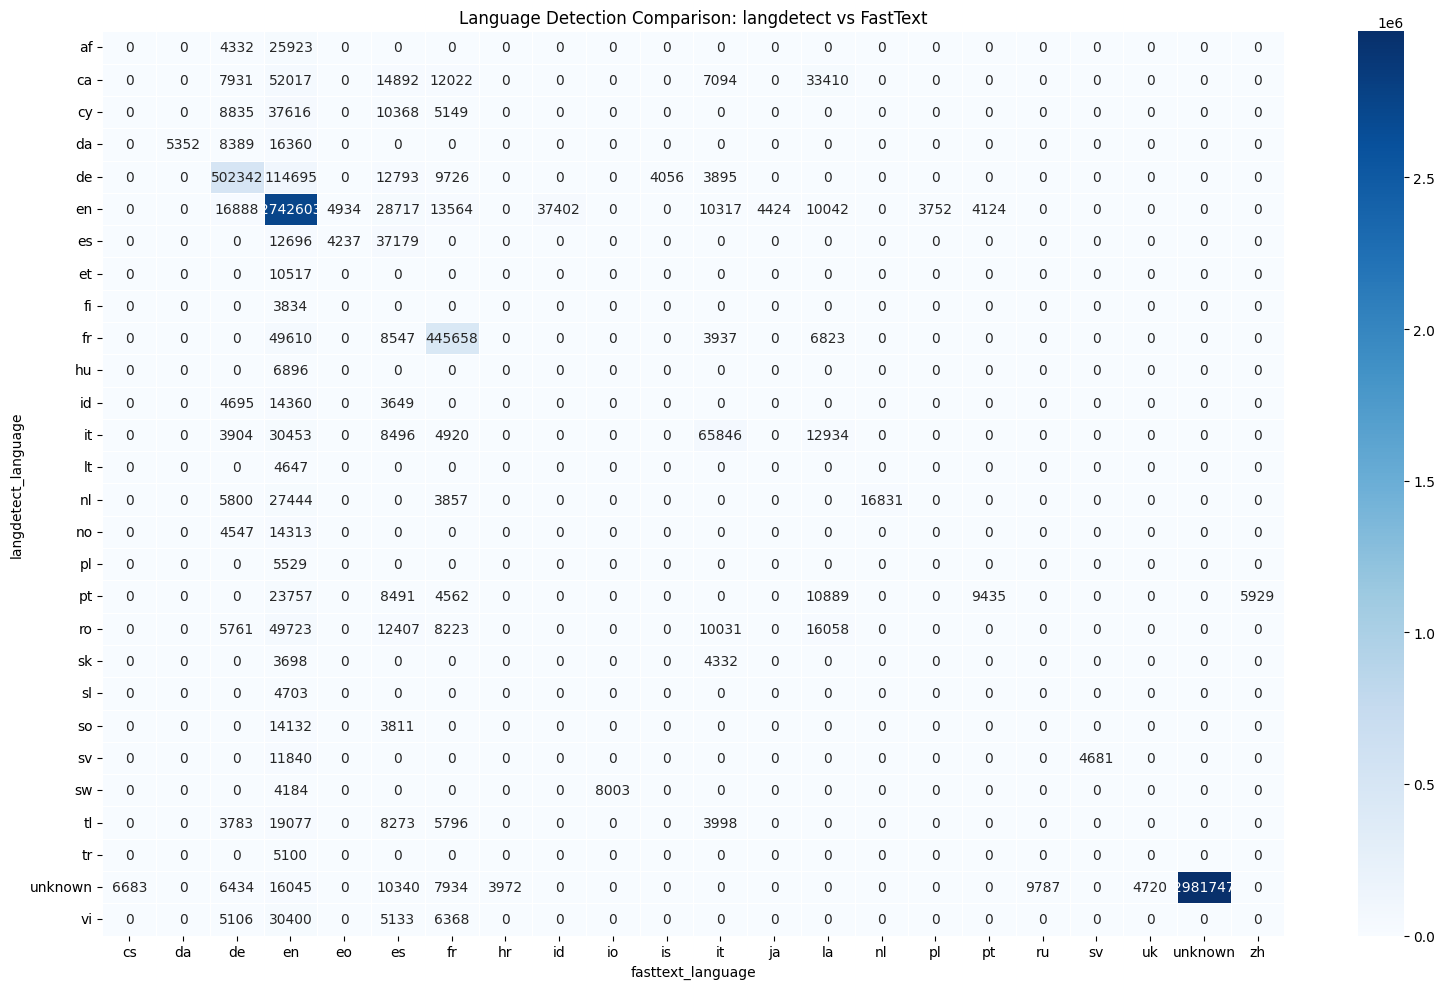

In [34]:
# Merge the language detection results for comparison
# Load both tables
langdetect_df = spark.table("alto_sentence_with_langdetect_lang")
fasttext_df = spark.table("alto_sentence_with_fasttext_lang")

# Join the tables to compare results
comparison_df = langdetect_df.select("id", "sentence", "language").join(
    fasttext_df.select("id", "sentence", "fasttext_language"), 
    ["id", "sentence"]
)

# Rename columns for clarity
comparison_df = comparison_df.withColumnRenamed("language", "langdetect_language")

# Show sample comparison
print("Sample comparison of language detection methods:")
comparison_df.show(10, truncate=100)

# Count matching and non-matching classifications
matching = comparison_df.filter(comparison_df.langdetect_language == comparison_df.fasttext_language).count()
non_matching = comparison_df.filter(comparison_df.langdetect_language != comparison_df.fasttext_language).count()
total = comparison_df.count()

print(f"\nAgreement between langdetect and FastText:")
print(f"Matching classifications: {matching} ({matching/total*100:.2f}%)")
print(f"Non-matching classifications: {non_matching} ({non_matching/total*100:.2f}%)")

# Let's look at some examples where the classifications differ
print("\nSample sentences where classifications differ:")
comparison_df.filter(comparison_df.langdetect_language != comparison_df.fasttext_language) \
    .select("sentence", "langdetect_language", "fasttext_language") \
    .show(10, truncate=150)

# Visualize the comparison with a confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get the top 10 languages from both methods
top_langs_comparison = comparison_df.groupBy("langdetect_language", "fasttext_language").count() \
    .orderBy("count", ascending=False) \
    .limit(100) \
    .toPandas()

# Create a confusion matrix
plt.figure(figsize=(16, 10))
confusion_matrix = top_langs_comparison.pivot_table(
    values="count", 
    index="langdetect_language", 
    columns="fasttext_language", 
    fill_value=0
)
# Convert confusion_matrix values to integers to avoid ValueError with fmt="d"
sns.heatmap(confusion_matrix.astype(int), annot=True, fmt="d", cmap="Blues", linewidths=.5)
plt.title("Language Detection Comparison: langdetect vs FastText")
plt.tight_layout()
plt.show()

# Conclusion

FastText offers several advantages over langdetect for language identification:

1. **Speed**: FastText is generally faster than langdetect when processing large amounts of text
2. **Accuracy**: It typically offers better language detection accuracy, especially for short texts or ambiguous language
3. **Language Coverage**: FastText can recognize 176 languages, which is more than many other language detection tools
4. **Consistency**: FastText provides more consistent results across similar text samples

The differences in the language distributions between the two methods highlight how important the choice of language detection tool can be when processing multilingual datasets.

# FastText entire corpus

In [ ]:
# delete table dir from hdfs using hdfs dfs -rm -r /user/hive/warehouse/alto_sentence_with_lang

#!hdfs dfs -rm -r /user/hive/warehouse/alto_sentence_with_lang

Deleted /user/hive/warehouse/alto_sentence_with_lang


In [46]:
df_fasttext_lang = spark.table("alto_sentence").mapInPandas(
    fasttext_language_mapin,
    schema="id string, sentence string, sentence_idx int, fasttext_language string"
)

df_fasttext_lang.write.saveAsTable(
    "alto_sentence_with_lang",
    mode="overwrite")